In [822]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [823]:
# Read in data
dat = pd.read_csv('listings.csv')
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            6366 non-null   int64  
 1   listing_url                                   6366 non-null   object 
 2   scrape_id                                     6366 non-null   float64
 3   last_scraped                                  6366 non-null   object 
 4   name                                          6366 non-null   object 
 5   description                                   6352 non-null   object 
 6   neighborhood_overview                         4663 non-null   object 
 7   picture_url                                   6366 non-null   object 
 8   host_id                                       6366 non-null   int64  
 9   host_url                                      6366 non-null   o

<h2>Data Cleansing</h2>

<h4>Drop off irrelevant columns:</h4>

* URLs will not be useful
* Empty columns: 'neighborhood_group_cleansed', 'bathrooms', 'calendar_updated'
* 'neighborhood' column only has blank values or 'Chicago, Illinois, United States' value
* 'scrape_id' is all the same value and not useful for our model
* 'last_scraped', 'calendar_last_scraped', 'host_neighbourhood' will not be useful

In [824]:
dat = dat.drop(['scrape_id','listing_url','host_url','host_thumbnail_url','host_picture_url','picture_url',
               'neighbourhood_group_cleansed','bathrooms','calendar_updated','neighbourhood',
               'last_scraped', 'calendar_last_scraped','host_neighbourhood'], axis = 1)

<h4>Bathrooms Column:</h4>

First, we will split the bathroom text column into two: one containing a float variable for the number of bathrooms, and the other an additional descriptor of the bathroom (shared/private).

In [825]:
# First let us make all text lowercase to simplify string manipulation

dat['bathrooms_text'] = dat['bathrooms_text'].str.lower()

# Next we must convert any text 'half' to 0.5 so it is included in the subsequent number extraction

dat['bathrooms_text'] = dat['bathrooms_text'].str.replace(r'(half)+','0.5', regex = True)

# Then extract the numbers into the new 'bathrooms' float32 data type column

dat['bathrooms'] = dat['bathrooms_text'].str.extract(r'(\d+\.?\d*)', expand = True).astype(np.float32)

# This leaves us with only float and NaN values

dat['bathrooms'].unique()

array([ 1. ,  2. ,  1.5,  3. ,  2.5,  0. ,  3.5, 11. ,  5. ,  nan,  0.5,
        4. ,  4.5, 11.5,  6.5,  7. ,  5.5,  6. ,  8. , 12.5, 10. ],
      dtype=float32)

<h4>Bathrooms Text Column:</h4>

In [826]:
# Remove the text 'bath', unnecessary symbols and whitespace, then extract the leftover text

dat['bathrooms_text'] = dat['bathrooms_text'].str.replace(r'(bath)s*|(Bath)s*','', regex = True)
dat['bathrooms_text'] = dat['bathrooms_text'].str.replace(r' +|\.+|\-+','', regex = True)
dat['bathrooms_text'] = dat['bathrooms_text'].str.extract(r'(\D+)')

In [827]:
dat['bathrooms_text'].unique()

array(['shared', nan, 'private'], dtype=object)

This leaves us with only two bathroom descriptors, 'shared' and 'private', as well as NaN values.

<h4>DateTime Columns:</h4>

In [828]:
# Convert dates to datetime data type

dat['host_since'] = pd.to_datetime(dat['host_since'])
dat['first_review'] = pd.to_datetime(dat['first_review'])
dat['last_review'] = pd.to_datetime(dat['last_review'])

<h4>Rate Columns:</h4>

In [829]:
# Convert host response rate and acceptance rate columns into float

dat['host_response_rate'] = dat['host_response_rate'].str.replace(r'(\D)','', regex = True).astype(np.float32)/100
dat['host_acceptance_rate'] = dat['host_acceptance_rate'].str.replace(r'(\D)','', regex = True).astype(np.float32)/100

<h4>Boolean Columns:</h4>

In [830]:
# Map superhost column to boolean values

# Need to check this, I think empty values are converted to False:
dat['host_is_superhost'] = dat['host_is_superhost'].map({'t':True,'f':False}).astype('bool')

# These do not convert to boolean, but keeps the empty/nan values:
dat['host_has_profile_pic'] = dat['host_has_profile_pic'].map({'t':True,'f':False})
dat['host_identity_verified'] = dat['host_identity_verified'].map({'t':True,'f':False})

In [831]:
dat['host_is_superhost'].unique()

array([ True, False])

<h4>Price Column:</h4>

Convert the price column to a float data type.

In [832]:
dat['price'] = dat['price'].str.extract(r'(\d+\.\d+)').astype(np.float64)

<h4>Host Dataset</h4>

Create a separate host dataset

In [833]:
host_dat = dat[['host_id','host_name','host_since','host_location','host_about','host_response_time',
                  'host_response_rate','host_acceptance_rate','host_is_superhost','host_listings_count',
                  'host_total_listings_count','host_verifications','host_has_profile_pic',
                  'host_identity_verified']]
host_dat = host_dat.drop_duplicates(subset=['host_id'])
host_dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3371 entries, 0 to 6360
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   host_id                    3371 non-null   int64         
 1   host_name                  3370 non-null   object        
 2   host_since                 3370 non-null   datetime64[ns]
 3   host_location              3362 non-null   object        
 4   host_about                 2115 non-null   object        
 5   host_response_time         2425 non-null   object        
 6   host_response_rate         2425 non-null   float32       
 7   host_acceptance_rate       2567 non-null   float32       
 8   host_is_superhost          3371 non-null   bool          
 9   host_listings_count        3370 non-null   float64       
 10  host_total_listings_count  3370 non-null   float64       
 11  host_verifications         3371 non-null   object        
 12  host_h

Then drop off these columns (except host_id) from the listings dataset.

In [834]:
dat = dat.drop(['host_name','host_since','host_location','host_about','host_response_time',
                  'host_response_rate','host_acceptance_rate','host_is_superhost','host_listings_count',
                  'host_total_listings_count','host_verifications','host_has_profile_pic',
                  'host_identity_verified'], axis = 1)
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 49 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            6366 non-null   int64         
 1   name                                          6366 non-null   object        
 2   description                                   6352 non-null   object        
 3   neighborhood_overview                         4663 non-null   object        
 4   host_id                                       6366 non-null   int64         
 5   neighbourhood_cleansed                        6366 non-null   object        
 6   latitude                                      6366 non-null   float64       
 7   longitude                                     6366 non-null   float64       
 8   property_type                                 6366 non-null   object

<h2>Exploring the Datasets</h2>

Let us explore the data in the dataset.

<h4>Unique Hosts</h4>

First, how many unique hosts are there?

In [835]:
dat['host_id'].nunique()

3371

In [836]:
dat['host_id'].nunique() == len(host_dat['host_id'])

True

In [837]:
listings_by_host = dat['host_id'].value_counts()
listings_by_host.describe()

count    3371.000000
mean        1.888460
std         5.548921
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       260.000000
Name: host_id, dtype: float64

In [838]:
listings_by_host[listings_by_host > 1].count()

799

Here we can see that out of the 3,371 unique hosts, 799 have more than one listing in the Chicago area.  Interestingly, there is one host id with 260 listings.

Let's graph this data to see the distribution of hosts with differing numbers of listings.

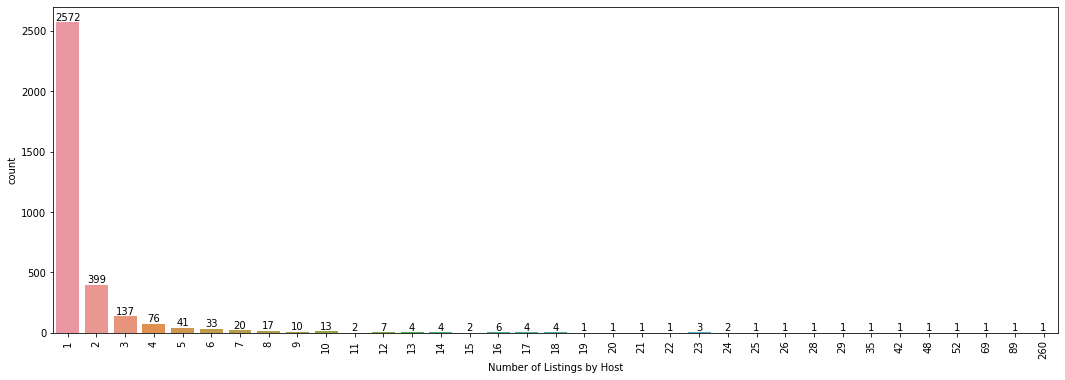

In [839]:
plt.figure(figsize=(18,6))
p = sb.countplot(x=listings_by_host, order=sorted(listings_by_host.unique()))
p.set_xticklabels(labels=p.get_xticklabels(),rotation=90)
p.bar_label(p.containers[0])
plt.xlabel('Number of Listings by Host')
plt.show()

<h4>Host Response Time</h4>


In [840]:
host_dat['host_response_time'].unique()

array(['within an hour', 'within a few hours', nan, 'within a day',
       'a few days or more'], dtype=object)

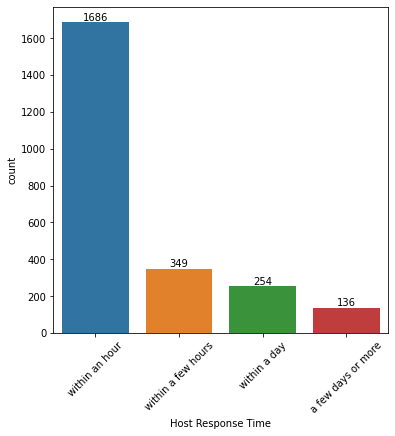

In [841]:
plt.figure(figsize=(6,6))
p = sb.countplot(x='host_response_time',data = host_dat)
p.set_xticklabels(labels=p.get_xticklabels(),rotation=45)
p.bar_label(p.containers[0])
plt.xlabel('Host Response Time')
plt.show()

Here we can see there are four categories for the response time.  Let's define a system for rating the response time by using floating numbers.  We will assign the values in hours and as follows:
 * 'within an hour' = 1 hour
 * 'within a few hours' = 5 hours
 * 'within a day' = 24 hours
 * 'a few days or more' = 48 hours

In [842]:
host_dat['host_response_time_float'] = host_dat['host_response_time'].map({'within an hour':1,'within a few hours':5,
                                                           'within a day':24,'a few days or more':48}).astype(np.float32)

<h4>Host Verifications</h4>

In order to simplify future analysis, let us count the number of verifications the host has and list this in a new column.

We can see that the verifications are separated by a comma, so we will use this to count the number of verifications each host has

In [843]:
host_dat['no_of_verif'] = host_dat['host_verifications'].str.count(r',') + 1
host_dat.loc[:, ['host_verifications','no_of_verif']].head()

,host_verifications,no_of_verif
0,"['email', 'phone', 'reviews', 'manual_offline'...",6
1,"['email', 'phone', 'reviews', 'jumio', 'offlin...",8
2,"['email', 'phone', 'reviews', 'jumio', 'govern...",6
3,"['email', 'phone', 'reviews', 'offline_governm...",7
4,"['email', 'phone', 'facebook', 'reviews', 'kba']",5


In order to catch any hosts that have no verifications, we will set the number of verifications to zero where the host_verifications = 'None'.

In [844]:
host_dat['no_of_verif'] = np.where(host_dat['host_verifications'] == 'None', 0, host_dat['no_of_verif'])
host_dat[host_dat['no_of_verif'] == 0]

,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,host_response_time_float,no_of_verif
6313,175128252,NaN,NaT,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,None,NaN,NaN,NaN,0


In [845]:
host_dat['no_of_verif'].describe()

count    3371.000000
mean        5.169386
std         2.168857
min         0.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        12.000000
Name: no_of_verif, dtype: float64

On average, hosts have about 5 different identity verifications. 

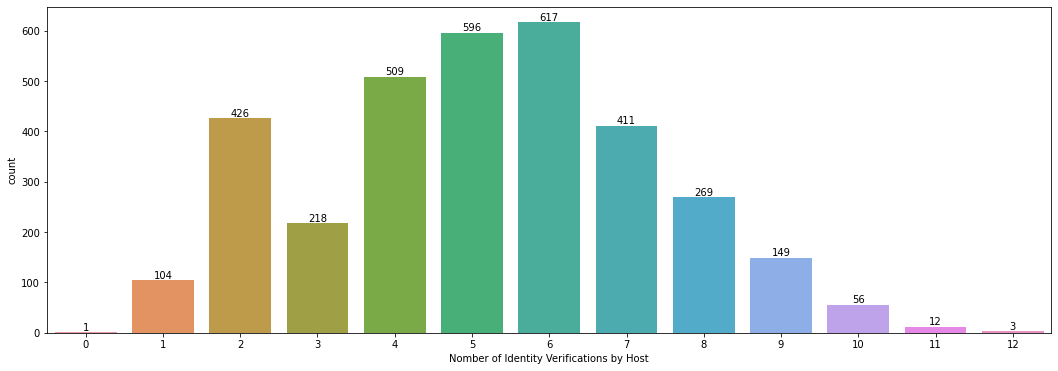

In [846]:
plt.figure(figsize=(18,6))
p = sb.countplot(x='no_of_verif',data = host_dat)
p.bar_label(p.containers[0])
plt.xlabel('Nomber of Identity Verifications by Host')
plt.show()

<h4>Amenities</h4>

Repeat the same process for number of amenities listed.

In [847]:
dat['no_of_amen'] = dat['amenities'].str.count(r',') + 1
dat.loc[:, ['amenities','no_of_amen']].head()

,amenities,no_of_amen
0,"[""Hot water kettle"", ""Wine glasses"", ""Kitchen""...",51
1,"[""Kitchen"", ""Free street parking"", ""Long term ...",30
2,"[""Kitchen"", ""Free street parking"", ""Shampoo"", ...",33
3,"[""Kitchen"", ""Long term stays allowed"", ""Smoke ...",31
4,"[""Free street parking"", ""Shampoo"", ""Smoke alar...",22


In [848]:
dat['no_of_amen'].describe()

count    6366.000000
mean       31.138549
std        10.615332
min         1.000000
25%        24.000000
50%        31.000000
75%        37.000000
max        82.000000
Name: no_of_amen, dtype: float64

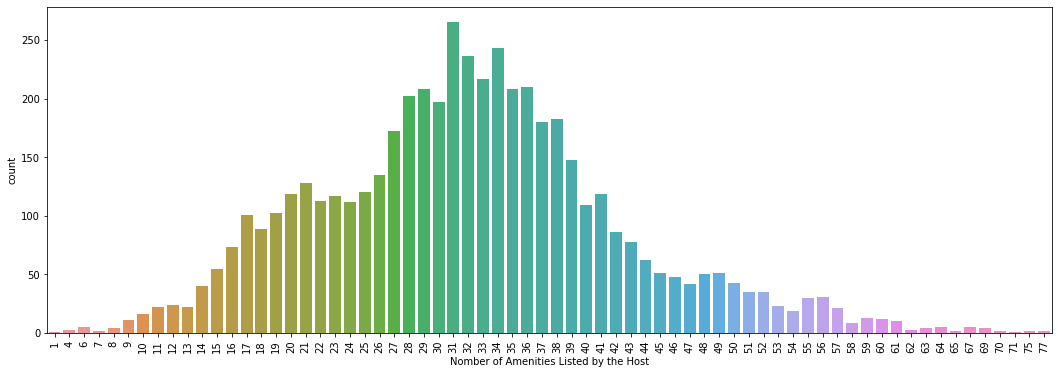

In [855]:
plt.figure(figsize=(18,6))
p = sb.countplot(x='no_of_amen',data = dat)
p.set_xticklabels(labels=p.get_xticklabels(),rotation=90)
plt.xlabel('Nomber of Amenities Listed by the Host')
plt.show()

In [850]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            6366 non-null   int64         
 1   name                                          6366 non-null   object        
 2   description                                   6352 non-null   object        
 3   neighborhood_overview                         4663 non-null   object        
 4   host_id                                       6366 non-null   int64         
 5   neighbourhood_cleansed                        6366 non-null   object        
 6   latitude                                      6366 non-null   float64       
 7   longitude                                     6366 non-null   float64       
 8   property_type                                 6366 non-null   object

In [854]:
dat = dat.dropna(thresh=len(dat.columns)-2)
dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5090 entries, 0 to 6300
Data columns (total 50 columns):
 #   Column                                        Non-Null Count  Dtype         
---  ------                                        --------------  -----         
 0   id                                            5090 non-null   int64         
 1   name                                          5090 non-null   object        
 2   description                                   5090 non-null   object        
 3   neighborhood_overview                         4066 non-null   object        
 4   host_id                                       5090 non-null   int64         
 5   neighbourhood_cleansed                        5090 non-null   object        
 6   latitude                                      5090 non-null   float64       
 7   longitude                                     5090 non-null   float64       
 8   property_type                                 5090 non-null   object

In [852]:
host_dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3371 entries, 0 to 6360
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   host_id                    3371 non-null   int64         
 1   host_name                  3370 non-null   object        
 2   host_since                 3370 non-null   datetime64[ns]
 3   host_location              3362 non-null   object        
 4   host_about                 2115 non-null   object        
 5   host_response_time         2425 non-null   object        
 6   host_response_rate         2425 non-null   float32       
 7   host_acceptance_rate       2567 non-null   float32       
 8   host_is_superhost          3371 non-null   bool          
 9   host_listings_count        3370 non-null   float64       
 10  host_total_listings_count  3370 non-null   float64       
 11  host_verifications         3371 non-null   object        
 12  host_h

In [853]:
host_dat = host_dat.dropna(thresh=len(host_dat.columns)-2)
host_dat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2425 entries, 0 to 6347
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   host_id                    2425 non-null   int64         
 1   host_name                  2425 non-null   object        
 2   host_since                 2425 non-null   datetime64[ns]
 3   host_location              2421 non-null   object        
 4   host_about                 1557 non-null   object        
 5   host_response_time         2425 non-null   object        
 6   host_response_rate         2425 non-null   float32       
 7   host_acceptance_rate       2368 non-null   float32       
 8   host_is_superhost          2425 non-null   bool          
 9   host_listings_count        2425 non-null   float64       
 10  host_total_listings_count  2425 non-null   float64       
 11  host_verifications         2425 non-null   object        
 12  host_h